In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score
import numpy as np

# Sample data as we don't have user data currently
np.random.seed(42)

# Generate 1000 records with biases
data = []
for _ in range(1000):
    cluster = np.random.choice(["A", "B", "C","D","E"], p=[0.2, 0.3, 0.2,0.05,0.25])  # Bias clusters
    user_feedback = (
        np.random.choice(range(1, 6), p=[0.1, 0.2, 0.3, 0.3, 0.1]) if cluster == "C" else
        np.random.choice(range(1, 6), p=[0.3, 0.2, 0.2, 0.2, 0.1])
    )
    cluster_false = (
        0 if user_feedback <= 2 and cluster == "B" else
        0 if user_feedback == 1 else
        1
    )
    data.append({"cluster": cluster, "user_feedback": user_feedback, "cluster_false": cluster_false})

df = pd.DataFrame(data)

# print(df.head())


label_encoder = LabelEncoder()
df["cluster_encoded"] = label_encoder.fit_transform(df["cluster"])
# LabelEncoder: Encodes categorical text labels into numerical form.
# fit_transform: Fits the encoder to the unique values in the "cluster" column and transforms the column into numerical values. For example:
# "A" → 0
# "B" → 1
# "C" → 2

X = df[["cluster_encoded", "user_feedback"]]
y = df["cluster_false"]
# X: Features used for prediction (independent variables). It includes:
# cluster_encoded: Encoded cluster labels.
# user_feedback: User feedback scores.
# y: Target variable (dependent variable). Here, cluster_false indicates whether the cluster label is false.

# Split data into train-test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a pipeline for scaling and logistic regression
pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("log_reg", LogisticRegression())
])
# Pipeline: Combines multiple steps into a single workflow:
# scaler: Scales the input features using StandardScaler.
# log_reg: Fits a logistic regression model to the scaled data.

pipeline.fit(X_train, y_train)
# fit: Trains the entire pipeline (scaling + logistic regression) using the training data.

y_pred = pipeline.predict(X_test)
# predict: Generates predictions for the test data using the trained pipeline.

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
# accuracy_score: Calculates the overall accuracy of predictions.
# classification_report: Provides detailed metrics like precision, recall, and F1-score for the classification results.

# Predict probabilities for a sample new input
sample_input = pd.DataFrame({"cluster_encoded": [1], "user_feedback": [3]})
# sample_input: Creates a new data point with:
# Cluster "B" (encoded as 1).
# User feedback score of 3.

probabilities = pipeline.predict_proba(sample_input)
print("Probability of satisfying answer:", probabilities[0][1])
# predict_proba: Returns the predicted probabilities for each class.
# probabilities[0][1]: The probability of the positive class (cluster_false = 1), indicating the likelihood of the cluster label being false.


Accuracy: 0.93
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.77      0.87        61
           1       0.91      1.00      0.95       139

    accuracy                           0.93       200
   macro avg       0.95      0.89      0.91       200
weighted avg       0.94      0.93      0.93       200

Probability of satisfying answer: 0.9930156606121222


In [2]:
!pip install faker

  Using cached Faker-33.1.0-py3-none-any.whl.metadata (15 kB)
Using cached Faker-33.1.0-py3-none-any.whl (1.9 MB)


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report, accuracy_score
from faker import Faker
import numpy as np

# Initialize Faker
fake = Faker()
np.random.seed(42)

# Generate 1000 records with synthetic text data
data = []
for _ in range(1000):
    cluster = np.random.choice(["A", "B", "C", "D", "E"], p=[0.2, 0.3, 0.2, 0.05, 0.25])  # Bias clusters
    user_feedback = (
        np.random.choice(range(1, 6), p=[0.1, 0.2, 0.3, 0.3, 0.1]) if cluster == "C" else
        np.random.choice(range(1, 6), p=[0.3, 0.2, 0.2, 0.2, 0.1])
    )
    cluster_false = (
        0 if user_feedback <= 2 and cluster == "B" else
        0 if user_feedback == 1 else
        1
    )
    # Generate synthetic feedback text using Faker
    feedback_text = (
        fake.paragraph(nb_sentences=2) if user_feedback >= 4 else
        fake.sentence(nb_words=10) if user_feedback == 3 else
        fake.text(max_nb_chars=50)
    )
    data.append({"cluster": cluster, "user_feedback": user_feedback, 
                 "cluster_false": cluster_false, "feedback_text": feedback_text})

df = pd.DataFrame(data)

# Encode categorical cluster column
label_encoder = LabelEncoder()
df["cluster_encoded"] = label_encoder.fit_transform(df["cluster"])

# Features and target
X = df[["cluster_encoded", "user_feedback", "feedback_text"]]
y = df["cluster_false"]

# Split data into train-test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Preprocess text data with TF-IDF and scale numerical data
preprocessor = ColumnTransformer([
    ("tfidf", TfidfVectorizer(), "feedback_text"),  # Text feature
    ("scaler", StandardScaler(), ["cluster_encoded", "user_feedback"])  # Numeric features
])

# Create a pipeline for preprocessing and logistic regression
pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("log_reg", LogisticRegression())
])

# Fit the pipeline on the training data
pipeline.fit(X_train, y_train)

# Predict on the test data
y_pred = pipeline.predict(X_test)

# Print metrics
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

# Predict probabilities for a sample new input
sample_input = pd.DataFrame({
    "cluster_encoded": [1],  # Cluster "B"
    "user_feedback": [3],  # User feedback score
    "feedback_text": ["The response was detailed but slightly unclear."]  # Text feedback
})
probabilities = pipeline.predict_proba(sample_input)
print("Probability of satisfying answer:", probabilities[0][1])


Accuracy: 0.915
Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.77      0.85        61
           1       0.91      0.98      0.94       139

    accuracy                           0.92       200
   macro avg       0.92      0.87      0.89       200
weighted avg       0.92      0.92      0.91       200

Probability of satisfying answer: 0.9937908505596939


/home/harsh/python_envs/notebook_env/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


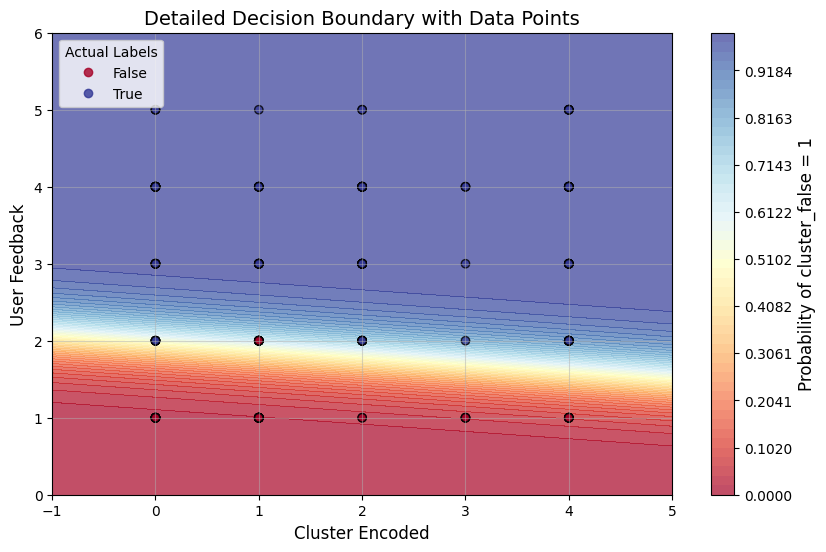

In [13]:
import matplotlib.pyplot as plt
import numpy as np

# Updated plotting function
def plot_decision_boundary(X, y, model):
    # Generate a denser grid
    x_min, x_max = X.iloc[:, 0].min() - 1, X.iloc[:, 0].max() + 1
    y_min, y_max = X.iloc[:, 1].min() - 1, X.iloc[:, 1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300), np.linspace(y_min, y_max, 300))  # More points

    # Predict probabilities for the grid
    grid_points = np.c_[xx.ravel(), yy.ravel()]
    probabilities = model.predict_proba(grid_points)[:, 1]
    zz = probabilities.reshape(xx.shape)

    # Plot the decision boundary
    plt.figure(figsize=(10, 6))
    contour = plt.contourf(xx, yy, zz, levels=np.linspace(0, 1, 50), cmap="RdYlBu", alpha=0.7)
    cbar = plt.colorbar(contour)
    cbar.set_label("Probability of cluster_false = 1", fontsize=12)

    # Plot the original data points
    scatter = plt.scatter(X.iloc[:, 0], X.iloc[:, 1], c=y, cmap="RdYlBu", edgecolor="k", alpha=0.8)
    legend = plt.legend(handles=scatter.legend_elements()[0], labels=["False", "True"], loc="upper left")
    legend.set_title("Actual Labels")

    plt.xlabel("Cluster Encoded", fontsize=12)
    plt.ylabel("User Feedback", fontsize=12)
    plt.title("Detailed Decision Boundary with Data Points", fontsize=14)
    plt.grid(True, alpha=0.5)
    plt.show()

# Fit the pipeline (already done in your code)
pipeline.fit(X_train, y_train)

# Plot the decision boundary
plot_decision_boundary(X_test, y_test, pipeline)


/home/harsh/python_envs/notebook_env/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


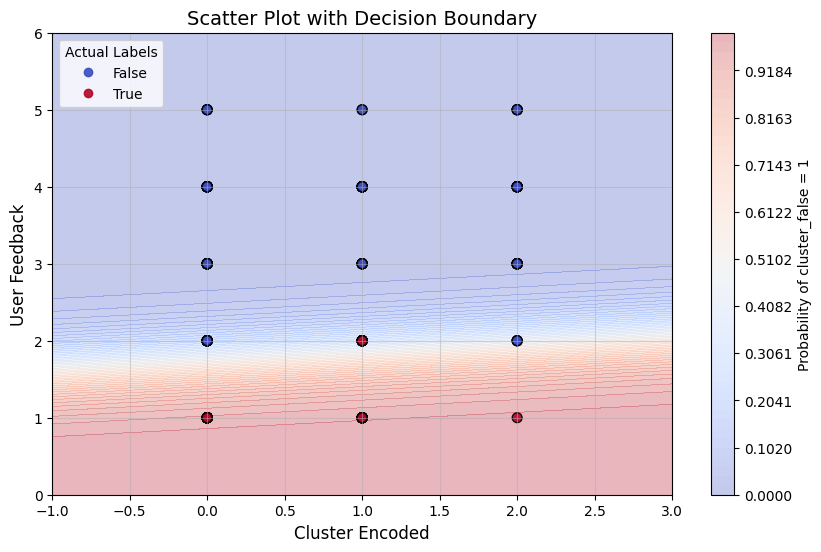

In [7]:
import matplotlib.pyplot as plt
import numpy as np

# Updated scatter plot with decision boundary
def scatter_decision_boundary(X, y, model):
    # Generate a dense grid of values
    x_min, x_max = X.iloc[:, 0].min() - 1, X.iloc[:, 0].max() + 1
    y_min, y_max = X.iloc[:, 1].min() - 1, X.iloc[:, 1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300), np.linspace(y_min, y_max, 300))

    # Predict probabilities for the grid
    grid_points = np.c_[xx.ravel(), yy.ravel()]
    probabilities = model.predict_proba(grid_points)[:, 1]
    zz = probabilities.reshape(xx.shape)

    # Plot the decision boundary
    plt.figure(figsize=(10, 6))
    plt.contourf(xx, yy, zz, levels=np.linspace(0, 1, 50), cmap="coolwarm", alpha=0.3)
    plt.colorbar(label="Probability of cluster_false = 1")

    # Plot the original data points
    scatter = plt.scatter(
        X.iloc[:, 0],
        X.iloc[:, 1],
        c=y,
        cmap="coolwarm",
        edgecolor="k",
        alpha=0.9,
        s=50
    )

    # Add a legend
    legend = plt.legend(
        handles=scatter.legend_elements()[0],
        labels=["False", "True"],
        title="Actual Labels",
        loc="upper left"
    )

    plt.xlabel("Cluster Encoded", fontsize=12)
    plt.ylabel("User Feedback", fontsize=12)
    plt.title("Scatter Plot with Decision Boundary", fontsize=14)
    plt.grid(True, alpha=0.5)
    plt.show()

# Fit the pipeline (already done in your code)
pipeline.fit(X_train, y_train)

# Plot the scatter decision boundary
scatter_decision_boundary(X_test, y_test, pipeline)
